## 3c.1. Import Thư Viện

In [2]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

print('Libraries imported')

Libraries imported


## 3c.2. Cấu Hình

In [3]:
# Tham số
VAL_SIZE = 0.15
SEED = 42
MAX_FEATURES = 10000
C_PARAM = 1.0
MAX_ITER = 1000

# Đường dẫn - LOAD TRỰC TIẾP TỪ CSV GỐC
DATA_DIR = './split_augmented_data'
TRAIN_CSV_PATH = os.path.join(DATA_DIR, 'train_augmented.csv')
TEST_CSV_PATH = os.path.join(DATA_DIR, 'test_original.csv')

OUT_DIR = './outputs_logistic'
os.makedirs(OUT_DIR, exist_ok=True)

print(f'Configuration set')
print(f'Output directory: {OUT_DIR}')

Configuration set
Output directory: ./outputs_logistic


## 3c.3. Load Data từ CSV

In [4]:
print('Loading CSV data...\n')

# Load train
df_train = pd.read_csv(TRAIN_CSV_PATH)
print(f'Train CSV loaded: {len(df_train):,} rows')

# Load test
df_test = pd.read_csv(TEST_CSV_PATH)
print(f'Test CSV loaded: {len(df_test):,} rows')

print(f'\nSample:')
print(df_train.head(2))

Loading CSV data...

Train CSV loaded: 59,995 rows
Test CSV loaded: 10,000 rows

Sample:
                                              review sentiment
0  I've been watching this movie by hoping to fin...  negative
1  A famous orchestra conductor, Daniel Dareus, s...  positive


## 3c.4. Extract Text và Labels

In [5]:
# Auto-detect column names
text_col = df_train.columns[0]
label_col = df_train.columns[1]

print(f'Detected columns: text="{text_col}", label="{label_col}"')

# Label mapping
label2idx = {'negative': 0, 'positive': 1}
idx2label = {0: 'negative', 1: 'positive'}

# Extract
train_texts = df_train[text_col].astype(str).values
train_labels = df_train[label_col].map(label2idx).values

test_texts = df_test[text_col].astype(str).values
test_labels = df_test[label_col].map(label2idx).values

print(f'Extracted:')
print(f'   Train: {len(train_texts):,} samples')
print(f'   Test: {len(test_texts):,} samples')

# Distribution
print(f'\nTrain distribution:')
for label, count in sorted(Counter(train_labels).items()):
    print(f'   {idx2label[label]}: {count:,} ({count/len(train_labels)*100:.1f}%)')

print(f'\nTest distribution:')
for label, count in sorted(Counter(test_labels).items()):
    print(f'   {idx2label[label]}: {count:,} ({count/len(test_labels)*100:.1f}%)')

Detected columns: text="review", label="sentiment"
Extracted:
   Train: 59,995 samples
   Test: 10,000 samples

Train distribution:
   negative: 29,997 (50.0%)
   positive: 29,998 (50.0%)

Test distribution:
   negative: 5,000 (50.0%)
   positive: 5,000 (50.0%)


## 3c.5. Train/Val Split

In [6]:
print(f'Splitting train/val ({100*(1-VAL_SIZE):.0f}%/{100*VAL_SIZE:.0f}%)...\n')

X_train, X_val, y_train, y_val = train_test_split(
    train_texts, train_labels,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=train_labels
)

print(f'Train: {len(X_train):,} samples')
print(f'Val: {len(X_val):,} samples')
print(f'Test: {len(test_texts):,} samples')

Splitting train/val (85%/15%)...

Train: 50,995 samples
Val: 9,000 samples
Test: 10,000 samples


## 3c.6. TF-IDF Vectorization

In [7]:
print('Creating TF-IDF features...\n')

vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),
    min_df=2,
    sublinear_tf=True,
    strip_accents='unicode'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(test_texts)

print(f'TF-IDF features:')
print(f'   Train: {X_train_tfidf.shape}')
print(f'   Val: {X_val_tfidf.shape}')
print(f'   Test: {X_test_tfidf.shape}')
print(f'   Vocab: {len(vectorizer.vocabulary_):,}')

Creating TF-IDF features...

TF-IDF features:
   Train: (50995, 10000)
   Val: (9000, 10000)
   Test: (10000, 10000)
   Vocab: 10,000


## 3c.7. Train Logistic Regression

In [8]:
print('\n' + '='*80)
print('TRAINING LOGISTIC REGRESSION')
print('='*80)

logreg = LogisticRegression(
    C=C_PARAM,
    max_iter=MAX_ITER,
    random_state=SEED,
    solver='lbfgs',
    class_weight='balanced',
    n_jobs=-1
)

print(f'Training...\n')
logreg.fit(X_train_tfidf, y_train)

print('Training completed!')
print(f'   Converged: {logreg.n_iter_[0] < MAX_ITER}')
print(f'   Iterations: {logreg.n_iter_[0]}')
print('='*80)


TRAINING LOGISTIC REGRESSION
Training...

Training completed!
   Converged: True
   Iterations: 20


## 3c.8. Evaluate on Validation Set

In [9]:
print('\nVALIDATION SET PERFORMANCE')
print('='*80)

val_preds = logreg.predict(X_val_tfidf)
val_probs = logreg.predict_proba(X_val_tfidf)
val_acc = accuracy_score(y_val, val_preds)
val_f1 = f1_score(y_val, val_preds, average='macro')

print(f'Accuracy: {val_acc:.4f}')
print(f'Macro F1: {val_f1:.4f}')
print(f'\nClassification Report:')
print(classification_report(y_val, val_preds, target_names=['negative', 'positive']))
print('='*80)


VALIDATION SET PERFORMANCE
Accuracy: 0.8933
Macro F1: 0.8933

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4500
    positive       0.89      0.90      0.89      4500

    accuracy                           0.89      9000
   macro avg       0.89      0.89      0.89      9000
weighted avg       0.89      0.89      0.89      9000



## 3c.9. Evaluate on Test Set


TEST SET PERFORMANCE (KHÔNG AUGMENT - KHÁCH QUAN)

Test Accuracy: 0.9045
Test Macro F1: 0.9045

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      5000
    positive       0.90      0.91      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



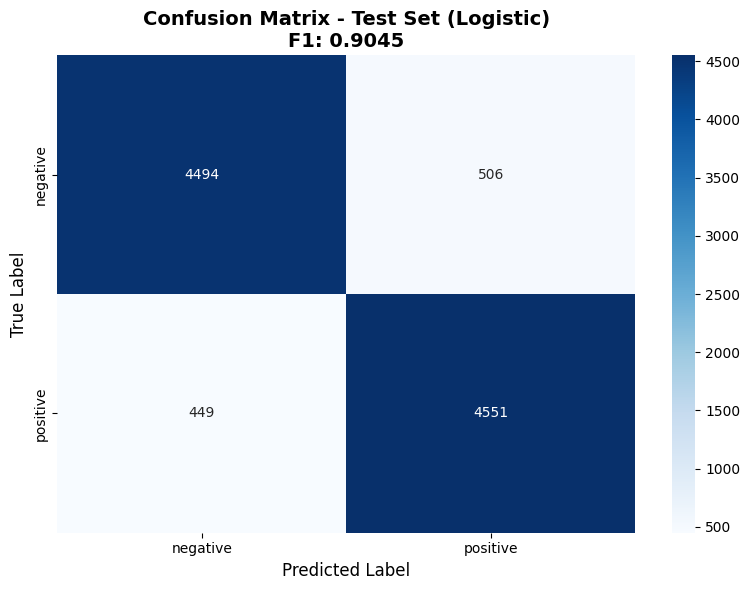

In [10]:
print('\n' + '='*80)
print('TEST SET PERFORMANCE (KHÔNG AUGMENT - KHÁCH QUAN)')
print('='*80)

test_preds = logreg.predict(X_test_tfidf)
test_probs = logreg.predict_proba(X_test_tfidf)
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='macro')

print(f'\nTest Accuracy: {test_acc:.4f}')
print(f'Test Macro F1: {test_f1:.4f}')
print(f'\nClassification Report:')
print(classification_report(test_labels, test_preds, target_names=['negative', 'positive']))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title(f'Confusion Matrix - Test Set (Logistic)\nF1: {test_f1:.4f}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'test_confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print('='*80)

## 3c.10. Feature Importance

In [11]:
print('\nTop Features:')
print('='*80)

feature_names = vectorizer.get_feature_names_out()
coef = logreg.coef_[0]

# Top positive
top_pos_idx = coef.argsort()[-20:][::-1]
print(f'\nTop 20 POSITIVE features:')
for idx in top_pos_idx:
    print(f'   {feature_names[idx]:25s} ({coef[idx]:+.4f})')

# Top negative
top_neg_idx = coef.argsort()[:20]
print(f'\nTop 20 NEGATIVE features:')
for idx in top_neg_idx:
    print(f'   {feature_names[idx]:25s} ({coef[idx]:+.4f})')

print('='*80)


Top Features:

Top 20 POSITIVE features:
   great                     (+7.4618)
   excellent                 (+6.7894)
   perfect                   (+4.8185)
   wonderful                 (+4.7451)
   amazing                   (+4.5166)
   brilliant                 (+4.3820)
   the best                  (+4.0624)
   loved                     (+3.9729)
   today                     (+3.9339)
   best                      (+3.8944)
   surprised                 (+3.8481)
   hilarious                 (+3.8046)
   superb                    (+3.6782)
   fun                       (+3.6753)
   enjoyed                   (+3.6131)
   definitely                (+3.4894)
   enjoyable                 (+3.4377)
   loved this                (+3.4246)
   fantastic                 (+3.3824)
   must see                  (+3.2945)

Top 20 NEGATIVE features:
   worst                     (-8.4218)
   bad                       (-8.1298)
   awful                     (-7.3367)
   boring                    (-7.2

## 3c.11. Probability Distribution Analysis

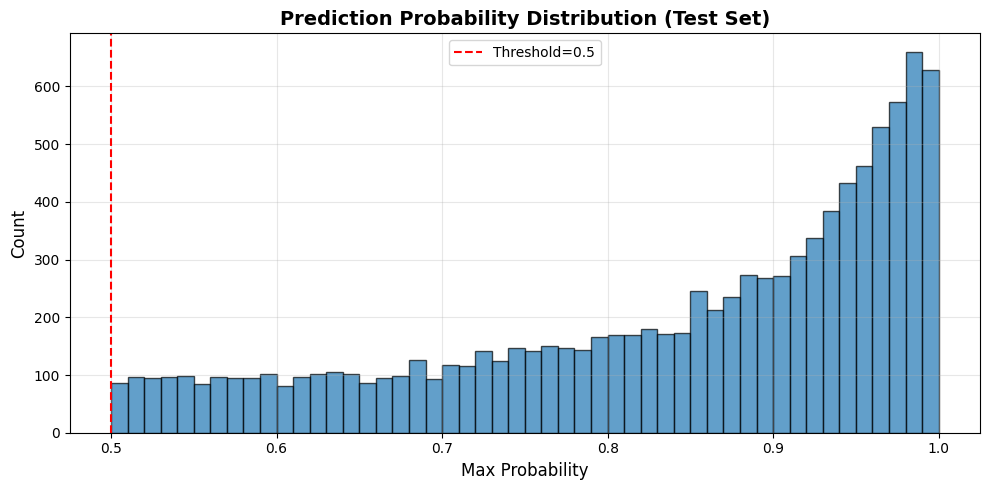


Probability Stats:
   Mean: 0.8392
   Median: 0.8849
   % > 0.9 (high conf): 45.82%
   % < 0.6 (low conf): 9.41%


In [12]:
test_max_probs = np.max(test_probs, axis=1)

plt.figure(figsize=(10, 5))
plt.hist(test_max_probs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold=0.5')
plt.title('Prediction Probability Distribution (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Max Probability', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'probability_distribution.png'), dpi=150)
plt.show()

print(f'\nProbability Stats:')
print(f'   Mean: {test_max_probs.mean():.4f}')
print(f'   Median: {np.median(test_max_probs):.4f}')
print(f'   % > 0.9 (high conf): {(test_max_probs > 0.9).sum() / len(test_max_probs) * 100:.2f}%')
print(f'   % < 0.6 (low conf): {(test_max_probs < 0.6).sum() / len(test_max_probs) * 100:.2f}%')

## 3c.12. Save Model & Metadata

In [13]:
# Save model
model_path = os.path.join(OUT_DIR, 'logreg_model.pkl')
joblib.dump(logreg, model_path)

# Save vectorizer
vectorizer_path = os.path.join(OUT_DIR, 'tfidf_vectorizer.pkl')
joblib.dump(vectorizer, vectorizer_path)

# Save metadata
model_meta = {
    'model_type': 'LogisticRegression',
    'val_accuracy': float(val_acc),
    'val_macro_f1': float(val_f1),
    'test_accuracy': float(test_acc),
    'test_macro_f1': float(test_f1),
    'C': C_PARAM,
    'max_iter': MAX_ITER,
    'converged': bool(logreg.n_iter_[0] < MAX_ITER),
    'iterations': int(logreg.n_iter_[0]),
    'data_source': 'CSV (split_augmented_data)'
}

meta_path = os.path.join(OUT_DIR, 'meta.json')
with open(meta_path, 'w', encoding='utf-8') as f:
    json.dump(model_meta, f, indent=2, ensure_ascii=False)

print('\nSaved:')
print(f'   {model_path}')
print(f'   {vectorizer_path}')
print(f'   {meta_path}')


Saved:
   ./outputs_logistic\logreg_model.pkl
   ./outputs_logistic\tfidf_vectorizer.pkl
   ./outputs_logistic\meta.json


## 3c.13. Summary

In [14]:
print('\n' + '='*80)
print('LOGISTIC REGRESSION COMPLETED!')
print('='*80)

print(f'\nSummary:')
print(f'   Model: Logistic Regression (lbfgs)')
print(f'   Features: TF-IDF (max={MAX_FEATURES}, ngrams=1-2)')
print(f'   Data: CSV gốc (không qua encoding)')
print(f'   Converged: {logreg.n_iter_[0] < MAX_ITER} ({logreg.n_iter_[0]} iterations)')

print(f'\nPerformance:')
print(f'   Val: Acc={val_acc:.4f}, F1={val_f1:.4f}')
print(f'   Test: Acc={test_acc:.4f}, F1={test_f1:.4f}')

print(f'\nFiles in {OUT_DIR}:')
for file in sorted(os.listdir(OUT_DIR)):
    fpath = os.path.join(OUT_DIR, file)
    if os.path.isfile(fpath):
        print(f'   - {file:30s} ({os.path.getsize(fpath)/1024:>8.1f} KB)')

print('\n' + '='*80)


LOGISTIC REGRESSION COMPLETED!

Summary:
   Model: Logistic Regression (lbfgs)
   Features: TF-IDF (max=10000, ngrams=1-2)
   Data: CSV gốc (không qua encoding)
   Converged: True (20 iterations)

Performance:
   Val: Acc=0.8933, F1=0.8933
   Test: Acc=0.9045, F1=0.9045

Files in ./outputs_logistic:
   - logreg_model.pkl               (    79.0 KB)
   - meta.json                      (     0.3 KB)
   - probability_distribution.png   (    40.5 KB)
   - test_confusion_matrix.png      (    47.5 KB)
   - tfidf_vectorizer.pkl           (   329.9 KB)

